In [33]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    ParseConfig, parse_from_file, markdown
)

In [31]:
parser = ParseConfig('\n\n', ParseConfig(' map:\n',
    [str, ParseConfig('\n', ParseConfig(' ', int))]
))

parsed_data = parse_from_file('puzzle_input\\day_5.txt', parser)

# seeds have their own format
temp =  parsed_data[0][0].split(': ')[-1]
seeds = ['seeds', [int(value) for value in temp.split(' ')]]
# disregard the seeds item leaving the other mappings
mappings = parsed_data[1:]

print(f'{str(seeds)[:60]}...')
print(f'{str(mappings[1])[:60]}...')

['seeds', [3429320627, 235304036, 1147330745, 114559245, 168...
['soil-to-fertilizer', [[3793729374, 3825015981, 63222599], ...


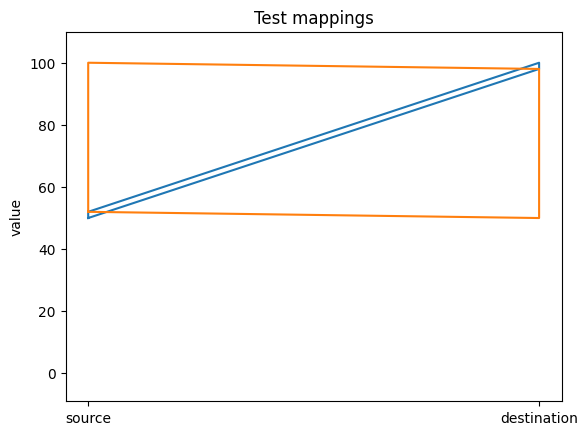

In [47]:
class Mapper:
    """does on-the-fly mappings to save having to store big lists"""
    def __init__(self, mappings: list[list[int, int, int]]):
        self._mappings = mappings
    
    def convert(self, value: int) -> int:
        """uses the mapping values to figure out how to convert the value"""
        for sour, dest, widt in self._mappings:
            if sour <= value < sour + widt:
                return dest + (value - sour)
        else:
            return value
    
    def plottable(
            self, ax: plt.Axes, x: tuple = (0, 1)) -> list[list[int, int]]:
        """pops mappings onto an axis"""
        x0, x1 = x
        x_series = [x0, x1, x1, x0, x0]
        for sour, dest, widt in self._mappings:
            series =[sour, dest, dest + widt, sour + widt, sour]
            ax.plot(x_series, series)
    

# this is from the example
mapper = Mapper([[50, 98, 2], [52, 50, 48]])

def mapping_plot(
        mapper: Mapper, title: str, y_limits: tuple[int] = None) -> None:
    """sets up a plot"""
    fig, ax = plt.subplots()
    mapper.plottable(ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['source', 'destination'])
    ax.set_ylabel('value')
    ax.set_title(title)
    if y_limits is not None:
        offset = y_limits[1] * 0.1
        ax.set_ylim(y_limits[0] - offset, y_limits[1] + offset)

mapping_plot('Test mappings', (1, 100))